In [118]:
import io
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class SelfOrganizingMap:
    def __init__(self, input_size, weight_size, hyper_params, weight_init_type='center'):
        self.input_size = input_size
        self.init_sigma = hyper_params['sigma']
        self.hyper_params = hyper_params
        self.fig_arr = []
        self.weight_init_type = weight_init_type

        # 初始化 dummy weight points
        self.weight = np.zeros((*weight_size, input_size))

        # weight points init 為 -1 ~ 1 的 uniform distribution
        # self.weight = np.random.uniform(-1, 1, self.weight.shape)

        # 產生一個 (h, w, 2) 的 index 矩陣，後續 find_winner 計算較為方便
        self.position_mat = np.array([[(i, j) for j in range(weight_size[1])]\
                                      for i in range(weight_size[0])])
    
    def weight_init(self, weight, data, type='center'):
        if type == 'center':
            # 將 weight points init 為 data 的中心點
            for each_dim in range(data.shape[1]):
                weight[:, :, each_dim] = np.ones(weight[:, :, each_dim].shape) *\
                                              np.mean(data[:, each_dim])
        elif type == 'uniform':
            # 將 weight points init 為 data 每個維度的最小, 最大值
            # 之間的 uniform distribution
            for each_dim in range(data.shape[1]):
                weight[:, :, each_dim] = np.random.uniform(data[:, each_dim].min(), 
                                                                data[:, each_dim].max(), 
                                                                weight[:, :, each_dim].shape)
        return weight
    
    def sigma_decaying(self, sigma, max_iter):
        return [sigma * np.exp(-it / max_iter) for it in range(max_iter)]
    
    def cal_alpha(self, winner_pos, sigma):
        distance = np.linalg.norm(winner_pos - self.position_mat, axis=2)
        # 用 gaussian function 計算每個 weight point 
        # 被更新程度的比例，距離 winner point 愈近愈大
        # alpha -> (h, w) -reshape-> (h, w, 1)
        return np.exp(-(distance**2) / (2 * sigma**2))\
            .reshape(self.weight.shape[0], self.weight.shape[1], 1)
    
    def cal_input_weight_distance(self, x):
        # 將所有 weight point 個別減去同個 x 後取歐式距離 (L2 norm)
        x_reshaped = x.reshape(1, 1, -1)
        distances = np.linalg.norm(self.weight - x_reshaped, axis=2)
        return distances

    def find_winner(self, x):
        distances = self.cal_input_weight_distance(x)

        # 找到距離當前 x 最近的 weight point 的 index
        winner_idx = np.unravel_index(distances.argmin(), distances.shape)
        return np.array(winner_idx)
    
    def train(self, data, save_gif=False, file_name='result.gif'):
        self.weight = self.weight_init(self.weight, data, self.weight_init_type)
        n_samples = len(data)
        np.random.shuffle(data)
        total_iter = self.hyper_params['epochs'] * n_samples
        err_arr = []

        self.sigma_arr = self.sigma_decaying(self.init_sigma, total_iter)

        for epoch in range(self.hyper_params['epochs']):    
            for i, x in enumerate(data):
                cur_iter = epoch * n_samples + i
                sigma = self.sigma_arr[cur_iter]
                winner_pos = self.find_winner(x)
                alpha = self.cal_alpha(winner_pos, sigma)
                self.weight += (self.hyper_params['lr'] * alpha * (x - self.weight))
                if i % 10 == 0:
                    if save_gif:
                        self.plot_mesh(data, cur_data=x, save_gif=True, title=[epoch, i])
                    err_arr.append(self.cal_error(data))

        if save_gif:
            self.fig_arr[0].save(file_name, save_all=True, 
                                 append_images=self.fig_arr[1:], 
                                 loop=0, duration=100)

        return err_arr

    def plot_convergence(self, err_arr):
        plt.figure(figsize=(6, 5))
        plt.plot(err_arr, 'b-')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.grid(True)
        plt.show()

    def cal_error(self, data):
        total_err = 0
        # 算出所有 data 與最近的權重的距離後取平均
        for x in data:
            # 找到最近的權重向量
            min_distance = np.min(self.cal_input_weight_distance(x))
            total_err += min_distance
        return total_err / len(data)
    
    def plot_mesh(self, data, cur_data=None, show_plot=False, save_gif=False, title=None):
        fig = plt.figure(figsize=(5, 5))

        if cur_data is not None:
            plt.scatter(cur_data[0], cur_data[1], c='r', marker='x')
        
        plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5, marker='x')
        
        # weight -> (h, w, input_size) -> (h*w, input_size)
        weight_2d = self.weight.reshape(-1, self.input_size)
        
        plt.scatter(weight_2d[:, 0], weight_2d[:, 1], marker='o', facecolors='none', edgecolors='black')
        
        # 水平方向的 weight point 連接
        for i in range(self.weight.shape[0]):
            for j in range(self.weight.shape[1] - 1):
                w1 = self.weight[i, j]
                w2 = self.weight[i, j + 1]
                plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'b-', linewidth=1)
        
        # 垂直方向的 weight point 連接
        for i in range(self.weight.shape[0] - 1):
            for j in range(self.weight.shape[1]):
                w1 = self.weight[i, j]
                w2 = self.weight[i + 1, j]
                plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'r-', linewidth=1)
        
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlabel('x')
        plt.ylabel('y')
        if title:
            plt.title(f'Epoch: {title[0]}, Iter: {title[1]}')
        if show_plot:
            plt.show()
        if save_gif:
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            image = Image.open(buf)
            self.fig_arr.append(image.copy())  
            plt.close(fig)
            buf.close()
        

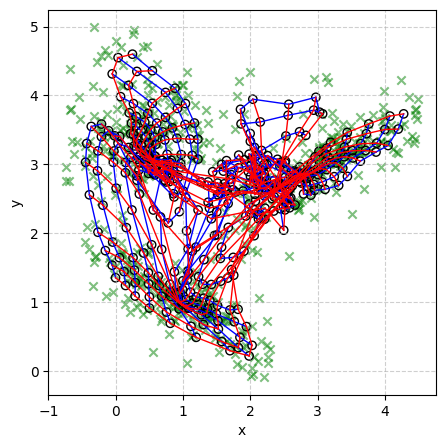

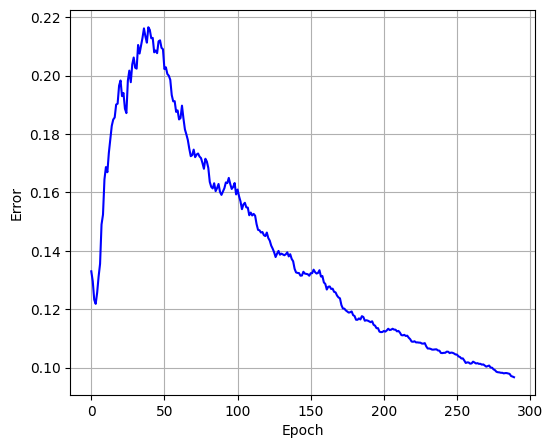

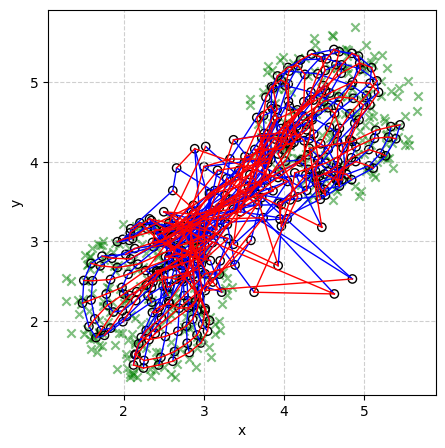

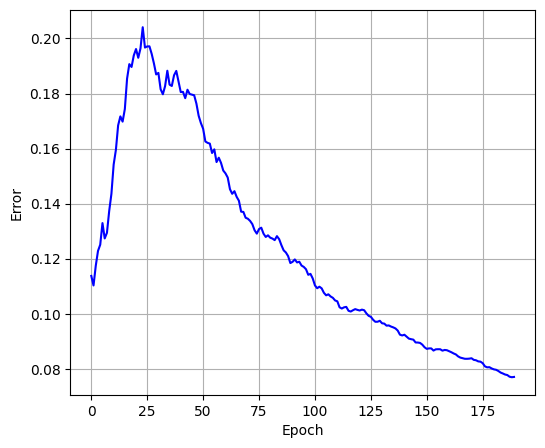

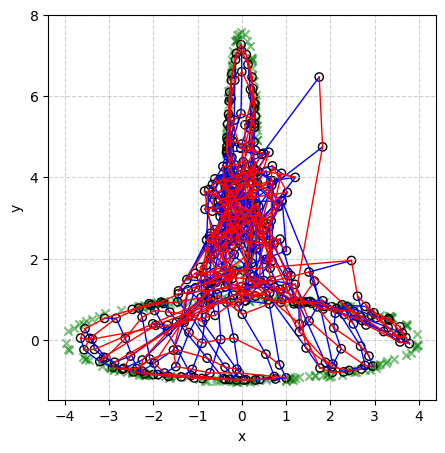

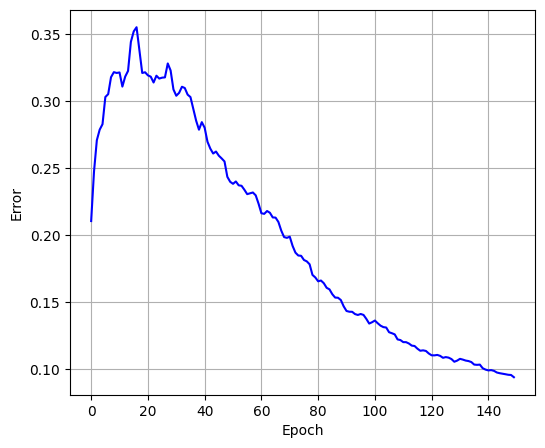

In [121]:
paths = os.listdir('data')

all_data = []

for path in paths:
    with open('data/' + path, 'r') as f:
        data = f.readlines()
    data = [x.strip().split('\t') for x in data]
    all_data.append(data)

# 固定隨機種子
np.random.seed(0)

for idx in range(len(all_data)):

    data = np.array(all_data[idx], dtype=np.float32)

    hyper_params = {
        'lr': 0.1,
        'epochs': 5,
        'sigma': 2.0
    }

    som = SelfOrganizingMap(2, (20, 20), hyper_params, 'uniform')

    err_arr = som.train(data, save_gif=True, file_name=f'result{idx}.gif')
    som.plot_mesh(data, show_plot=True)
    som.plot_convergence(err_arr)


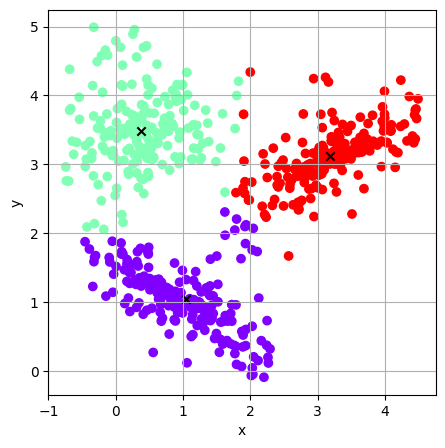

In [120]:
# k-means

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

a = np.array(all_data[0], dtype=np.float32)
KMeans_model = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(a)


plt.figure(figsize=(5, 5))
plt.scatter(a[:, 0], a[:, 1], c=KMeans_model.labels_, cmap='rainbow')
plt.scatter(KMeans_model.cluster_centers_[:, 0], KMeans_model.cluster_centers_[:, 1], c='black', marker='x')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.show()



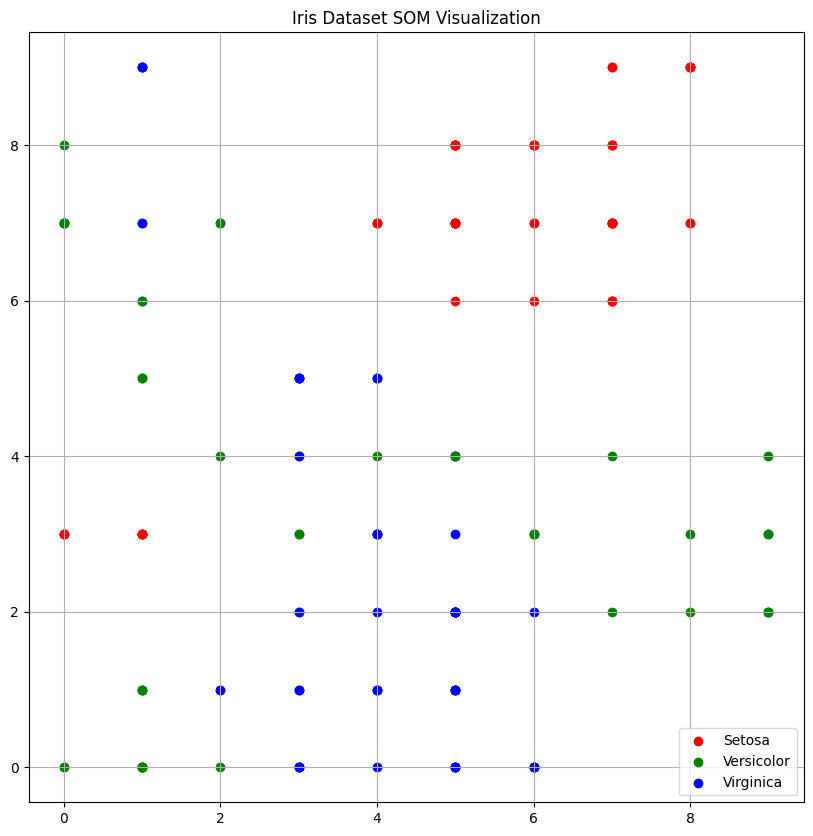

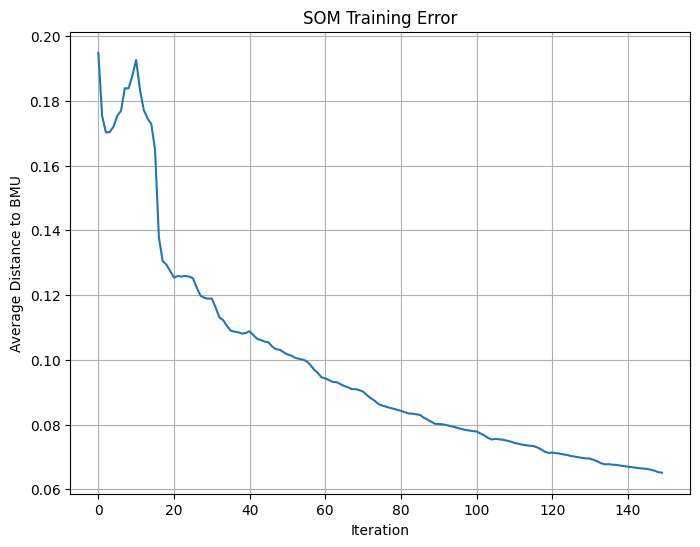

In [110]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from PIL import Image
import io

# 載入你原本的 SelfOrganizingMap 類別
# [前面的 SelfOrganizingMap 類別保持不變]

# 主程式
def main():
    # 載入 iris dataset
    iris = load_iris()
    X = iris.data
    y = iris.target
    
    # 資料預處理：將特徵縮放到 [0,1] 區間
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 設定 SOM 參數
    input_size = X.shape[1]  # 4 個特徵
    weight_size = (10, 10)   # 10x10 的網格
    hyper_params = {
        'epochs': 10,
        'lr': 0.1,
        'sigma': 1.0
    }
    
    # 初始化並訓練 SOM
    som = SelfOrganizingMap(input_size, weight_size, hyper_params, weight_init_type='uniform')
    err_arr = som.train(X_scaled, save_gif=True, file_name='iris_som.gif')
    
    # 視覺化最終結果
    plt.figure(figsize=(10, 10))
    
    # 對每個資料點找到最接近的 weight point (winner)
    winners = np.zeros((len(X_scaled), 2))
    for i, x in enumerate(X_scaled):
        winners[i] = som.find_winner(x)
    
    # 繪製結果，使用不同顏色表示不同類別
    plt.scatter(winners[y==0, 0], winners[y==0, 1], c='red', label='Setosa')
    plt.scatter(winners[y==1, 0], winners[y==1, 1], c='green', label='Versicolor')
    plt.scatter(winners[y==2, 0], winners[y==2, 1], c='blue', label='Virginica')
    
    plt.title('Iris Dataset SOM Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 繪製收斂曲線
    plt.figure(figsize=(8, 6))
    plt.plot(err_arr)
    plt.title('SOM Training Error')
    plt.xlabel('Iteration')
    plt.ylabel('Average Distance to BMU')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()